## Description

Notes on Generative Adversarial Networks (GANs)

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Overview

Fundamental principal behing GANs is competition between **two** neural nets - a ***Generator*** and a ***Discriminator***. The generator *generates* an output and the discriminator tries to identify whether the output is real or correct. In a sense it's like training by optimizing a loss function with a target except that instead of a target we have a second model that is training to identify whether the output or prediction matches the target... so the target is like the discriminator's expectations for the output or prediction. The feadback of the discriminator trains the generator to generate improving outputs. 

## Maths Deep Dive

High level, what are discriminative and generative models?
- Discriminative: Learn conditional probability of target variable given an input variable $$\text{P}(Y|X=x)$$
- Generative: Learn joint probability distribution of the input variable and output (target) variable, draws predictions using condtional probability of the target variable given the input variable via Baye's theorem $$\text{P}(Y|X) = \text{P}(X, \ Y) / \text{P}(X)$$

Generative models allow us to *generate* new input data; this is because they learn the distribution of the input data, not just the output (or target) data.

Let's define $Z$ as noise, i.e. noise data, and $X$ as original input data. $Z$ is used as an input to the generator, $G(\cdot)$, such that $G(z)$ yields a distribution which we seek to approximate the distribution of $X$. Because the objective is to replicate the distribution of $X$, the *support* of $G(z)$ must be the same as the *domain* of $X$. This probability density function is denoted $p_g(x)$ and is defined over the domain of $x$.

Let's clear up some notation regarding the propability distributions:
- $p_g(x)$ -- the probability distribution of the generated data
- $p_{\text{data}}(x)$ -- the probability distribution of the original data
- $p_z(z)$ -- the probability distribution of the noise data

### Objectives and Value Function

Now, let's define the *objectives* of the generator and discriminator in plain terms:
- Generator Objective: Learn the distribution of the original data $X$
- Discriminator Objective: Learn the probability that input data belongs to the original dataset

So, the discriminator will take input from the generator *and* from the original data and attempt to determine the source of the data; i.e., predict $1$ for authentic data and $0$ for generated data.

This is a two-player ***MiniMax Game*** - a game wherein one player attempts to maximize their probability of winning while to other attempts to minimize their opponent's probability of winning. This is expressed in the following *Value Function* from the GAN paper:
$$\min_{G}\max_{D}V(D,G) = \mathbb{E}_{x\sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log (1 - D(G(z)))]$$

- $\min_G$ denotes that we choose the *function* $G(\cdot)$ such that $V(D,G)$ is minimized
- $\max_D$ denotes that we choose the *function* $D(\cdot)$ such that $V(D,G)$ is maximized

Let's look at a similar, common loss function, *Binary Cross-Entropy*:
$$\mathcal{L} = -\sum y\ln \hat{y} + (1-y) \ln (1- \hat{y})$$
- when $y=1$, $\hat{y} = D(x) \implies \mathcal{L} = \ln [D(x)]$
- when $y=0$, $\hat{y} = D(G(z)) \implies \mathcal{L} = \ln [1-D(G(z))]$

Now, the $\mathbb{E}$ in the value function denotes the expectation of each expression on the subscripted distribution of the independent variable. So, $\mathbb{E}_{x\sim p_{\text{data}}(x)}[\log D(x)]$ is the expected value of $\log D(x)$ for $x$ drawn from a distribution of $p_{\text{data}}(x)$. Likewise, $\mathbb{E}_{z\sim p_z(z)}[\log (1 - D(G(z)))]$ is the expected value of $\log(1-D(G(z)))$ for $z$ drawn from a distribution of $p_z(z)$.

So, another way we may express the value function is:
$$\sum p_{\text{data}}(x) \ln [D(x)] + \sum p_z(z)\ln[1-D(G(z))], \ \ \text{for discrete} \ x, \ z$$
$$\int p_{\text{data}}(x) \ln [D(x)] dx + \int p_z(z)\ln[1-D(G(z))] dz, \ \ \text{for continuous} \ x, \ z$$

So, the value function overwhich we are optimizing is nothing more than the binary cross entropy loss function over in-distribution and out-of-distribution variables $x$ and $z$.

Ok, so why $\min_G$ and $\max_D$? 

Again, the objective of the discriminator is to correctly predict 1 when its input is $x$ and 0 when its input is $G(z)$. So, $$D(x) \rightarrow 1 \ \implies \log[D(x)] \rightarrow 0 \\ \ \\ D(G(z)) \rightarrow 0 \ \implies \log[1-D(G(z))] \rightarrow -\infty$$
Meanwhile, the objective of the generator is to generate data from a distribution that looks like the original data's distribution. So, $$D(G(z)) \rightarrow 1 \ \implies \log[1-D(G(z))] \rightarrow 0$$

### Training Loop

The GAN paper describes a nested training loop with a hyper-parameter $k$ which designates the number of iterations for the inner loop (paper uses $k=1$). Here's the pseudocode algorithm:

**for** `iter` in `training_iterations`:\
&emsp;**for** `step` in `k`:\
        &emsp;&emsp; - Sample minibatch of $m$ noise samples ${z^{(1)}, ..., z^{(m)}}$ from noise prior $p_g(z)$\
        &emsp;&emsp; - Sample minibatch of $m$ examples ${x^{(1)}, ..., x^{(m)}}$ from original data $p_{\text{data}}(x)$\
        &emsp;&emsp; - Update the discriminator by ***ascending*** its gradient:
        $$\nabla_{\theta_d}\frac{1}{m}\sum^m_{i=1} [ \log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))]$$
&emsp;**end for**\
&emsp; - Sample minibatch of $m$ noise samples ${z^{(1)}, ..., z^{(m)}}$ from noise prior $p_g(z)$\
&emsp; - Update the generator by ***descending*** its gradient:
        $$\nabla_{\theta_g}\frac{1}{m} \sum^m_{i=1} \log[1-D(G(z^{(i)}))]$$
**end for**

I'll worry about the derivation of these gradients later (backwards through and derive partial derivatives).

**NOTE:** We are using gradient *ascent* for the discriminator's updating rule and *descent* for the generator's updating rule. Why? Because the discriminator's objective is to *maximize* the loss function while the generator's objective is the *minimize* the loss function.

So, at each iteration, we must update *both* the discriminator and the generator. I do not have a strong intuition at this point for whether the order of updating matters. Perhaps we could update the generator before updating the discriminator and achieve similar results...?

### Global Optimality of $p_g = p_\text{data}$

The objective of the generator is to produce a distiribution $p_g(z)$ that replicates, *converges to*, the distribution of the data $p_\text{data}$. If the training rule of $\min_G$ achieves this convergence, then this convergence must occur at the global minimum of the value function. From the paper:

**Proposition 1:** For $G$ fixed, the optimal discriminator $D$ is
$$D^*_G(x) = \frac{p_\text{data}(x)}{p_\text{data}(x) + p_g(x)}$$
*Proof:* \
The training criterion for the discriminator $D$, given any generator $G$, is to maximize the quantity $V(G,D)$. Because $G$ is fixed as a constant and because the support of $G(z)$ is the domain of $x$, we may express $V(G,D)$ as:
$$V(G,D) = \int_x p_\text{data}(x) \log[D(x)]dx + \int_z p_z(z) \log[1-D(g(z))]dz \\ \ \\ = \int_x p_\text{data}(x) \log[D(x)] + p_g(x)\log[1-D(x)]dx$$
Now, for any $(a, b) \in \reals^2 \ne {0, 0}$, the function $y \rightarrow a\log(y) + b\log(1-y)$ achieves it's maximum within $[0,1]$ at $\frac{a}{a+b}$. Because the support for the discriminator and the generator is defined on $[0,1]$, this statement proves the optimality of $D^*_G(x)$.

Restating the value function with fixed $G$ and optimal $D$: 
$$C(G) = \max_D V(G,D) = \mathbb{E}_{x\sim p_\text{data}}[\log D^*_G(x)] + \mathbb{E}_{x\sim P_g} [\log(1-D^*_G(x))]$$

**Theorem 1:** The global minimum of the virtual training criterion $C(G)$ is achieved if and only if $p_g = p_\text{data}$. At that point, $C(G)$ achieves the value $-\log 4$

*Proof:*\
For $p_g = p_\text{data}$, $D^*_G(x) = \frac{p_\text{data}}{2p_\text{data}} = \frac{1}{2}$; thus, $C(G) = 2\log\frac{1}{2} = -\log 4$

Now, the next part of the proof leans on a couple new concepts: Kullback-Leibler divergence and Jensen-Shannon divergence.

**KL Divergence**

Kullback-Leibler (KL) divergence is a measure of *statistical distance*. It measures the extent to which one reference probability distribution $P$ is different from a second probability distribution $Q$. It is defined as:
$$D_\text{KL}(P||Q) = \sum_{x\in \chi} P(x) \log \left(\frac{P(x)}{Q(x)}\right)$$
It may be interpreted as the expected *excess surprise* from using $Q$ as a model instead of $P$ when the actual distribution of $x$ is $P$.

**JS Divergence**

Jensen-Shannon (JS) divergence is a measure of the similarity between two probability distributions. It is based on KL divergence with some notable differences. For KL divergence $D(P||Q)$, the JS divergence is defined as:
$$ \text{JSD}(P||Q) = \frac{1}{2}D(P||M) + \frac{1}{2}D(Q||M)$$
where $M=\frac{1}{2}(P+Q)$ is a mixture distribution of $P$ and $Q$.

Now, let $P=p_\text{data}$ and $Q=p_g$, so $M = \frac{1}{2}(p_\text{data} + p_g)$; then,
$$\text{JSD}(P||Q) = \frac{1}{2} D(p_\text{data} || \frac{p_\text{data} + p_g}{2}) + \frac{1}{2} D(p_g || \frac{p_\text{data} + p_g}{2}) \\ \ \\ = \frac{1}{2}\mathbb{E}_{x\sim p_{\text{data}}(x)}\log \left(2\frac{p_\text{data}(x)}{p_\text{data}(x) + p_g} \right) + \frac{1}{2}\mathbb{E}_{x\sim p_g}\log \left( 2\frac{p_g}{p_\text{data}(x) + p_g} \right)$$
Factoring out $2$ and $\frac{1}{2}$:
$$= \mathbb{E}_{x\sim p_{\text{data}}(x)}\log \left(\frac{p_\text{data}(x)}{p_\text{data}(x) + p_g} \right) + \mathbb{E}_{x\sim p_g}\log \left( \frac{p_g}{p_\text{data}(x) + p_g} \right) - 2\ln 2 \\ \ \\ = 2 \text{JSD}(p_\text{data}||p_g) - 2\ln 2$$

**NOTE:** $\frac{p_g}{p_\text{data}(x) + p_g} = 1 - \frac{p_\text{data}(x)}{p_\text{data}(x) + p_g}$

Finally, a crucially property of JSD is that the JSD between two distributions is *always* non-negative and is zero *only* when the distributions are equal. Therefore, $-2\ln 2 = -\log 4$ is the global minimum of $C(G)$ and the only solution is $p_g=p_\text{data}$, i.e. the generative model perfectly replicating the data generating process.

## Demo
Fleshed-out demo from https://github.com/luisguiserrano/gans

Objective of this simple GAN is to learn to generate 2x2 matrices with a diagonal of ones and off-diagonal zeros. Such a matrix is called a `face` while a randomly generated 2x2 matrix is called `noise`.

Also, my notation isn't great in this section, I broadly use $\theta$ and $\mathbf{W}$ to denote model weights interchangeably because the paper uses $\theta$ when referring to weights.

In [6]:
# plotting function
def view_samples(samples, m, n):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=m, ncols=n, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(1-img.reshape((2,2)), cmap='Greys_r')  
    return fig, axes

In [9]:
# hyperparameters
lr = 1e3

Sigmoid function: $$ \sigma(x) = \frac{1}{1+e^{-x}}$$

In [8]:
def sigmoid(x): return 1 / (1 + np.exp(-x))

## Discriminator

In [499]:
# discriminator NN
class Discriminator():
    def __init__(self):
        self.weights = np.random.normal(size=4).reshape(2, 2)
        self.bias = np.random.normal() 

    def forward(self, x):
        """Forward pass with sigmoid function"""
        return sigmoid(x @ self.weights + self.bias)
    
    def error_from_face(self, face):
        """Loss from input image"""
        prediction = self.forward(face)
        return -np.log(prediction)  # train to predict 1, so loss is -log(prediction) i.e. -log(D(x))
    
    def derivatives_from_face(self, face):
        pred = self.forward(face)
        derivatives_weights = - face.T @ (1 - pred)
        derivative_bias = - (1 - pred)
        return derivatives_weights, derivative_bias
    
    def update_from_face(self, x):
        dw, db = self.derivatives_from_face(x)
        # decrement bc the gradients are negative (ascend w.r.t. faces -- we want to move in the opposite direction)
        self.weights -= lr * dw
        self.bias -= lr * db

    def error_from_noise(self, noise):
        pred = self.forward(noise)
        return -np.log(1 - pred)  # i.e. -log(1 - D(G(z)))
    
    def derivatives_from_noise(self, noise):
        pred = self.forward(noise)
        derivatives_weights = noise.T @ pred
        derivatives_bias = pred
        return derivatives_weights, derivatives_bias
    
    def update_from_noise(self, noise):
        dw, db = self.derivatives_from_noise(noise)
        # descend w.r.t. noise
        self.weights -= lr * dw
        self.bias -= lr * db

### Math for Discriminator Gradients

Note that this implimentation separates the value function into an error component for when the input is a face, $\log[D(x)]$, and for when the input is noise, $\log[1-D(G(z))]$. Then, we compute the gradients for each instance...

The derivative of the sigmoid function w.r.t. $x$: $$\frac{d}{dx}\sigma(x) = \sigma(x)(1-\sigma(x))$$

Deriving `derivatives_from_face`:
$$\frac{\partial \mathcal{L}}{\partial \theta_d} = \frac{\partial}{\partial \theta_d} \left[ -\ln\left(\sigma(\mathbf{X}\mathbf{W} + b)\right) \right] \\ \ \\ = \frac{-1}{\sigma(\mathbf{X}\mathbf{W} + b)} \mathbf{X^\intercal} \left[ \sigma(\mathbf{X}\mathbf{W} + b) (1 - \sigma(\mathbf{X}\mathbf{W} + b)) \right] \\ \ \\ = - \mathbf{X}^\intercal (1 - \sigma(\mathbf{X}\mathbf{W} + b)) \\ \ \\ \frac{\partial \mathcal{L}}{\partial b} = - (1 - \sigma(\mathbf{X}\mathbf{W} + b))$$

Deriving `derivatives_from_noise`:
$$\frac{\partial \mathcal{L}}{\partial \theta_d} = \frac{\partial}{\partial \theta_d} \left[ -\ln\left(1 - \sigma(\mathbf{X}\mathbf{W} + b)\right) \right] \\ \ \\ = \frac{-1}{1 - \sigma(\mathbf{X}\mathbf{W} + b)} \mathbf{X^\intercal}\left[ - \sigma(\mathbf{X}\mathbf{W} + b) (1 - \sigma(\mathbf{X}\mathbf{W} + b)) \right] \\ \ \\ = \mathbf{X}^\intercal \sigma(\mathbf{X}\mathbf{W} + b) \\ \ \\ \frac{\partial \mathcal{L}}{\partial b} = \sigma(\mathbf{X}\mathbf{W} + b)$$

## Generator

In [500]:
# for a scalar noise parameter z
class Generator():
    def __init__(self):
        self.weights = np.random.normal(size=4).reshape(2, 2)
        self.biases = np.random.normal(size=4).reshape(2, 2)
    
    def forward(self, z):
        return sigmoid(z * self.weights + self.biases)
    
    def error(self, z, discriminator):
        gz = self.forward(z)
        dgz = discriminator.forward(gz)
        return -np.log(dgz)  # i.e. -log(D(G(z))) -- as D(G(z)) --> 1, error --> 0
    
    def derivatives(self, z, discriminator):
        gz = self.forward(z)
        dgz = discriminator.forward(gz)
        derivatives_weights = z.T @ gz * (1 - gz) * -(1 - dgz) @ discriminator.weights.T # (dgz) @ discriminator.weights.T * (z.T @ gz * (1 - gz)).T
        derivatives_bias = gz * (1 - gz) * -(1 - dgz) @ discriminator.weights.T
        return derivatives_weights, derivatives_bias
    
    def update(self, z, discriminator):
        dw, db = self.derivatives(z, discriminator)
        self.weights -= lr * dw
        self.biases -= lr * db

### Math for Generator Derivatives

$$\frac{\partial \mathcal{L}}{\partial \theta_g} = \frac{\partial}{\partial \theta_g} -\log(D(G(z))) \\ \ \\ = \frac{-1}{D(G(z))} \cdot \frac{-\partial}{\partial \theta_g} D(G(z))$$

$$\frac{-\partial}{\partial \theta_g} D(G(z)) = -\frac{\partial D(G(z))}{\partial G(z)}\frac{\partial G(z)}{\partial \theta_g}$$

Leaning on the derivation presented for the discriminator:
$$\frac{\partial D(G(z))}{\partial G(z)} = \frac{\partial}{\partial G(z)} \sigma(G(z)\mathbf{W}_d + b) \\ \ \\ = \sigma(G(z)\mathbf{W}_d + b)\left[1 - \sigma(G(z)\mathbf{W}_d + b) \right]\mathbf{W}_d^\intercal$$

Then,
$$\frac{\partial G(z)}{\partial \theta_g} = \frac{\partial}{\partial \theta_g} \sigma(\mathbf{Z}\mathbf{W}_g + \mathbf{B}) \\ \ \\ = \mathbf{Z}^\intercal \sigma(\mathbf{Z}\mathbf{W}_g + \mathbf{B})\left[1 - \sigma(\mathbf{Z}\mathbf{W}_g + \mathbf{B})\right]$$

Putting everything together:
$$\frac{\partial \mathcal{L}}{\partial \theta_g} = -\left[1 - \sigma(G(z)\mathbf{W}_d + b)\right]\mathbf{W}_d^\intercal \ \cdot \ \mathbf{Z}^\intercal \sigma(\mathbf{Z}\mathbf{W}_g + \mathbf{B})\left[1 - \sigma(\mathbf{Z}\mathbf{W}_g + \mathbf{B})\right]$$
In other words:
$$-[1 - D(G(z))]\mathbf{W}_d^\intercal \cdot \mathbf{Z}^\intercal G(z)(1 - G(z))$$

However, I think we have to switch the ordering of the matrix operation, resulting in:
$$\mathbf{Z}^\intercal G(z)(1 - G(z)) \cdot - [1 -  D(G(z))]\mathbf{W}_d^\intercal$$

Then for the partial derivative w.r.t. the bias:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{B}} = G(z)(1 - G(z)) \cdot -[1 - D(G(z))]\mathbf{W}_d^\intercal$$ 

## Training

In [501]:
# "data"
faces = [
    np.array([[0.95, 0.07], [0.04, 0.92]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[0.88, 0.2], [0.08, 0.98]]),
    np.array([[0.8, 0.2], [0.1, 0.9]])
]
# hyperparameters
np.random.seed(42)
lr = 0.01
epochs = 1000

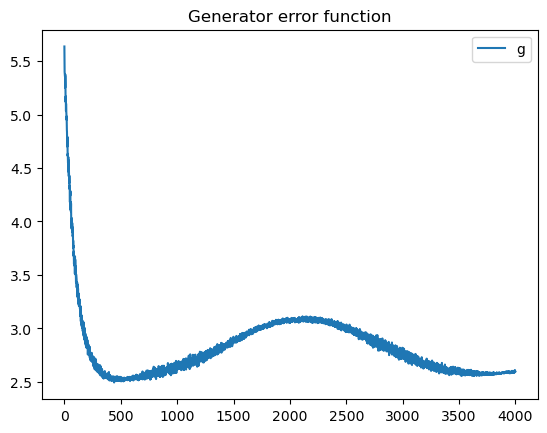

Text(0.5, 1.0, 'Discriminator error function')

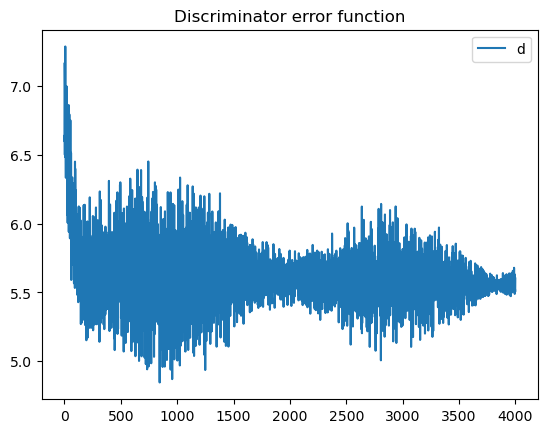

In [513]:
# The GAN
D = Discriminator()
G = Generator()

# For the error plot
errors_discriminator = []
errors_generator = []

for epoch in range(epochs):
        for face in faces:
                # face = face.reshape(4)
                # print(face)
                # Update the discriminator weights from the real face
                D.update_from_face(face)
        
                # generate noise
                z = np.random.random((2, 2))

                # Calculate the discriminator error
                errors_discriminator.append(sum(D.error_from_face(face) + D.error_from_noise(z)).sum())
                
                # Calculate the generator error
                errors_generator.append(G.error(z, D).sum())
                
                # Build a fake face
                noise = G.forward(z)
                
                # Update the discriminator weights from the fake face
                D.update_from_noise(noise)
        
                # Update the generator weights from the fake face
                G.update(z, D)

plt.plot(errors_generator)
plt.title("Generator error function")
plt.legend("gen")
plt.show()
plt.plot(errors_discriminator)
plt.legend('disc')
plt.title("Discriminator error function")

[[0.59117894 0.18110771]
 [0.152055   0.72334414]]
[[0.58462073 0.18860822]
 [0.16684791 0.71589334]]
[[0.61186656 0.15874304]
 [0.11197165 0.74628114]]
[[0.62627869 0.14430186]
 [0.0894706  0.76174256]]


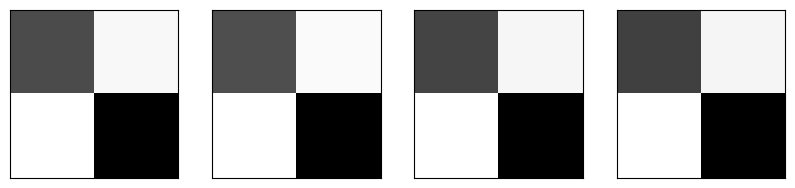

In [516]:
generated_images = []
for i in range(4):
    z = np.random.random()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
_ = view_samples(generated_images, 1, 4)
for i in generated_images:
    print(i)

## Huh

SO, this is really funky. The error progression is kinda wild but it looks like we end up somewhere in the right place..... more to investigate but good enough for now...